In [75]:
import numpy as np
import xarray as xr
import os
import matplotlib.pyplot as plt
import scipy
import scipy.stats as stats
import datetime
from datetime import datetime, timedelta, time
from scipy import signal
import pandas as pd

model_name = 'ecmwfsipn'
model_type = 'reforecast'
filepath = '/home/disk/sipn/nicway/data/model/{model_name}/{model_type}/sipn_nc_agg'.format(model_name=model_name,model_type=model_type)
filename = xr.open_mfdataset(filepath+'/*.nc',concat_dim='init_time')
#print(filename)
region_names = filename.region_names


<xarray.Dataset>
Dimensions:       (ensemble: 25, fore_time: 215, init_time: 288, nregions: 15)
Coordinates:
  * ensemble      (ensemble) int32 0 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24
  * fore_time     (fore_time) timedelta64[ns] 1 days 2 days ... 215 days
  * nregions      (nregions) int64 99 2 3 4 5 6 7 8 9 10 11 12 13 14 15
    region_names  (nregions) object 'panArctic' ... 'Central Arctic'
  * init_time     (init_time) datetime64[ns] 1993-01-01 ... 2016-12-01
Data variables:
    Extent        (init_time, ensemble, fore_time, nregions) float64 dask.array<shape=(288, 25, 215, 15), chunksize=(1, 25, 215, 15)>


In [35]:
region_sel = 0
no_ens = 25
extent = filename.Extent
extent_region = extent[:,:,:,region_sel]
print(extent_region.shape)

init_time = filename.init_time
forecast_times = filename.fore_time
print(init_time.shape)
fore_sel = 14 #only use first 14 days
extent_sel = extent_region[:,:,0:fore_sel]
print(extent_sel.shape)
forecast_time_sel = forecast_times[0:fore_sel]

(288, 25, 215)
(288,)
(288, 25, 14)


In [31]:
print(init_times)
multiplier = 86400000000000 #convert from nanoseconds to days
forecast_time_days = forecast_time_sel.values/multiplier
print(forecast_time_days)
start_date = np.array(init_time[0].values).astype('datetime64[D]')
init_dates = pd.DatetimeIndex(np.array(init_time.values))
#print(start_date,init_dates)
forecast_dates = start_date
#for idate in np.arange(0,len(forecast_time_days)):
#    idelta = start_date + np.timedelta64(forecast_time_days[idate]*multiplier,'D')
#    forecast_dates = np.append(forecast_dates,idelta)
    
#print(forecast_dates)

<xarray.DataArray 'init_time' (init_time: 288)>
array(['1993-01-01T00:00:00.000000000', '1993-02-01T00:00:00.000000000',
       '1993-03-01T00:00:00.000000000', ..., '2016-10-01T00:00:00.000000000',
       '2016-11-01T00:00:00.000000000', '2016-12-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * init_time  (init_time) datetime64[ns] 1993-01-01 1993-02-01 ... 2016-12-01
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]


In [72]:
#extent_create_SC = np.array(extent_sel).reshape((fore_sel*len(init_time)*no_ens),)
extent_create_SC = np.array(extent_sel)
#dates_SC = np.array([])
#extent_SC = np.array([])

for i_init in np.arange(0,len(init_time)):
    itime_init = init_time[i_init]
#i_init = 0
    itime_init = init_time[i_init]
    i_extent = extent_sel[i_init,:,:]
    iforecast_dates = itime_init
    for ifore in np.arange(0,fore_sel):
    #ifore = 0
        ifore_dates = np.array(itime_init).astype('datetime64[D]') + np.timedelta64(forecast_time_days[ifore]*multiplier,'D')
        iforecast_dates = np.append(iforecast_dates,ifore_dates)

    fdates_ens = np.tile(iforecast_dates[1:15],25)
   # print(fdates_ens.shape)
    #print(iforecast_dates.shape)
    extent_init = extent_create_SC[i_init,:,:]
    extent_rs = extent_init.reshape(fore_sel*no_ens,)
    if i_init == 0:
        dates_SC = fdates_ens
        extent_SC = extent_rs
    else:
        dates_SC = np.append(dates_SC,fdates_ens)
        extent_SC = np.append(extent_SC,extent_rs)
    #print(extent_rs.shape)

['1993-01-02T00:00:00.000000000' '1993-01-03T00:00:00.000000000'
 '1993-01-04T00:00:00.000000000' ... '2016-12-13T00:00:00.000000000'
 '2016-12-14T00:00:00.000000000' '2016-12-15T00:00:00.000000000']


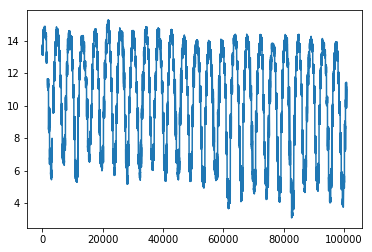

In [74]:
plt.plot(extent_SC)
print(dates_SC)


In [95]:
#remove SC by subtracting mean of all days with that date
date_SC = pd.DatetimeIndex(dates_SC)
for i_SC in np.arange(0,len(extent_SC)):
#i_SC = 1
    iex_SC = extent_SC[i_SC]
    idate_SC = date_SC[i_SC]
    #print(idate_SC)
    #idate_SC.month
    date_ind = np.where((date_SC.month == idate_SC.month) & (date_SC.day == idate_SC.day))
#print(iex_SC - np.nanmean(extent_SC[date_ind]))
    isc_e_anom = iex_SC - np.nanmean(extent_SC[date_ind])
    if i_SC == 0:
        extent_SC_remove = isc_e_anom
    else:
        extent_SC_remove = np.append(extent_SC_remove,isc_e_anom)
            

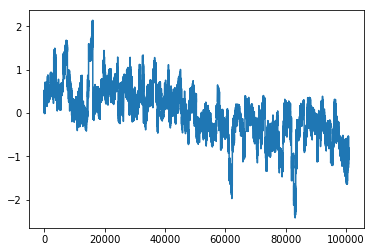

In [100]:
plt.plot(extent_SC_remove)

In [102]:
for idelta in np.arange(2,len(extent_SC_remove)-2):
    #i_sc = extent_SC_remove[idelta]
    delta = extent_SC_remove[idelta+2] - extent_SC_remove[idelta-2]
    if idelta == 2:
        SIC_delta = delta
    else:
        SIC_delta = np.append(SIC_delta,delta)

        

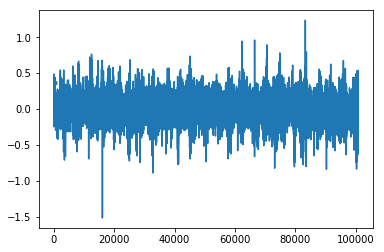

In [103]:
plt.plot(SIC_delta)

In [104]:
np.nanmean(SIC_delta)

-6.424497167196524e-05